## Import Library

In [1]:
import dgl
from dgl.data import DGLDataset
import os
import pandas as pd
import numpy as np
import torch
import itertools
import numpy as np
import scipy.sparse as sp
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
from dgl.nn.pytorch import conv as dgl_conv
from startup_data_set import COMP4222Dataset_hetero
from PredictorClasses import *
from CustomMetrics import *
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
device = torch.device('cpu')

### Hypermeters

In [2]:
val_ratio = 0.1
test_ratio = 0.1

# Hyperparameters
n_hidden = 64
n_layers = 2
dropout = 0.5

## Load Dataset

In [3]:
graph = COMP4222Dataset_hetero()[0]
graph = dgl.to_homogeneous(graph,ndata=['feat'],edata=['feat'])
graph

Graph(num_nodes=25446, num_edges=45621,
      ndata_schemes={'feat': Scheme(shape=(221,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(23,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)})

In [4]:
in_feats = graph.ndata['feat'].shape[1]
in_feats

221

## Generate Postitve Graph and Negative Graph with Spliting

In [5]:
from CustomUtilities import generate_neg_graph, generate_pos_graph
train_g, train_pos_g, val_pos_g, test_pos_g = \
    generate_pos_graph(graph, val_ratio, test_ratio)

train_g

Graph(num_nodes=25446, num_edges=61943,
      ndata_schemes={'feat': Scheme(shape=(221,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(23,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)})

In [6]:
train_neg_g, val_neg_g, test_neg_g = \
    generate_neg_graph(graph, val_ratio, test_ratio)

train_neg_g

Graph(num_nodes=25446, num_edges=36497,
      ndata_schemes={}
      edata_schemes={})

## Model Training

### Model Setup

In [7]:
class GCN(nn.Module):
    def __init__(self,
                 in_feats,
                 n_hidden,
                 out_dim):
        super().__init__()
        self.layers = nn.ModuleList()
        # two-layer GCN
        self.layers.append(
            dglnn.GraphConv(in_feats, n_hidden, activation=F.relu)
        )
        self.layers.append(dglnn.GraphConv(n_hidden, out_dim))
        self.dropout = nn.Dropout(dropout)

    def forward(self, g, features):
        h = features
        for i, layer in enumerate(self.layers):
            if i != 0:
                h = self.dropout(h)
            h = layer(g, h)
        return h

In [8]:
gat_model = GCN(
    in_feats,
    n_hidden,
    n_layers)

pred = DotPredictor()

### Training Loop

In [12]:
import itertools

train_loss, val_loss = [], []
train_AUC, val_AUC = [], []
stop = 0

optimizer = torch.optim.Adam(itertools.chain(gat_model.parameters(), pred.parameters()), lr=0.01)

for e in range(500):
    # forward
    h = gat_model(train_g, train_g.ndata['feat'].float())
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    train_loss.append(loss.item())
    train_AUC.append(compute_auc(pos_score, neg_score))

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # validation
    v_pos_score = pred(val_pos_g, h)
    v_neg_score = pred(val_neg_g, h)
    v_loss = compute_loss(v_pos_score, v_neg_score)
    val_loss.append(v_loss.item())
    val_AUC.append(compute_auc(v_pos_score, v_neg_score))

    #verbose
    if e % 5 == 0:
        print('Epoch: {} \t\t\t Train loss: {} \t\t\t Val loss: {}'.format(e, loss, v_loss))


    # early stopping
    if len(val_loss) > 2 and val_loss[-1] > val_loss[-2]:
        stop += 1
    if stop >= 30:
        print("Early Stopped at Epoch {}".format(e))
        break


Epoch: 0 			 Train loss: 0.6930486559867859 			 Val loss: 0.6931360363960266
Epoch: 5 			 Train loss: 0.689700186252594 			 Val loss: 0.6911910176277161
Epoch: 10 			 Train loss: 0.6772758960723877 			 Val loss: 0.6849640011787415
Epoch: 15 			 Train loss: 0.6626282930374146 			 Val loss: 0.6837107539176941
Epoch: 20 			 Train loss: 0.6336089968681335 			 Val loss: 0.669899046421051
Epoch: 25 			 Train loss: 0.5986636877059937 			 Val loss: 0.6952065825462341
Epoch: 30 			 Train loss: 0.5709031820297241 			 Val loss: 0.7512100338935852
Epoch: 35 			 Train loss: 0.5431036949157715 			 Val loss: 0.7423524260520935
Epoch: 40 			 Train loss: 0.5245490074157715 			 Val loss: 0.7390804886817932
Epoch: 45 			 Train loss: 0.5160744190216064 			 Val loss: 0.7786789536476135
Epoch: 50 			 Train loss: 0.5116016864776611 			 Val loss: 0.8083834052085876
Epoch: 55 			 Train loss: 0.5052202343940735 			 Val loss: 0.8109832406044006
Epoch: 60 			 Train loss: 0.5002270936965942 			 Val loss: 0.7917670

In [13]:
# testing AUC
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC:', compute_auc(pos_score, neg_score))

AUC: 0.7848323291295092


### Result Plotting

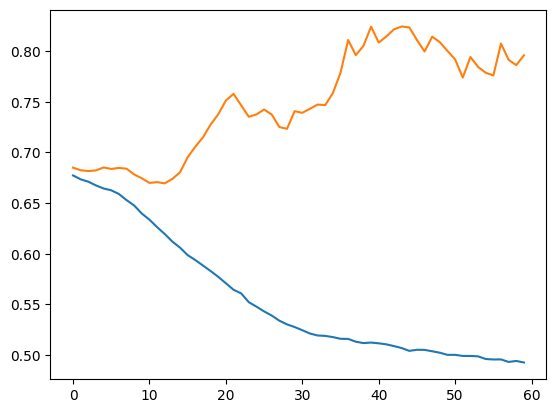

In [14]:

plt.plot(train_loss[10:])
plt.plot(val_loss[10:])

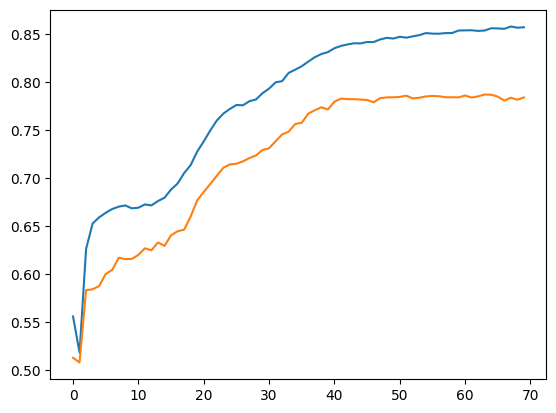

In [15]:
plt.plot(train_AUC)
plt.plot(val_AUC)